## Environment set up and import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [3]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [4]:
import os, keras, numpy,tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from tensorflow.keras import initializers

## **Discriminator** Model

In [5]:
def define_discriminator(in_shape=(128,128,3),n_classes=5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 200)(label_layer_1)
    label_layer_3 = Dense(in_shape[0] * in_shape[1])(label_layer_2)
    label_layer_4 = Reshape((in_shape[0], in_shape[1], 1))(label_layer_3)
    # (128, 128, 1)

    # input image
    input_image = Input(shape=in_shape, name = "input_image")
    # (128, 128, 3)

    concat_layer = Concatenate()([input_image, label_layer_4])
    # (128, 128, 4)

    conv2d_layer_1 = Conv2D(filters = 16, kernel_size = (3,3), strides = (2,2), padding='same')(concat_layer)
    conv2d_layer_1 = LeakyReLU(alpha=0.3)(conv2d_layer_1)
    # (64, 64, 16)

    conv2d_layer_2 = Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_1)
    conv2d_layer_2 = LeakyReLU(alpha=0.3)(conv2d_layer_2)
    # (32, 32, 32)

    label_layer_3_1 = Dense(32 * 32)(label_layer_2)
    label_layer_4_1 = Reshape((32, 32, 1))(label_layer_3_1)
    # (32, 32, 1)

    concat_layer_1 = Concatenate()([conv2d_layer_2, label_layer_4_1])
    # (32, 32, 33)

    conv2d_layer_3 = Conv2D(filters = 64, kernel_size = (3,3),  strides = (2,2), padding = 'same')(concat_layer_1)
    conv2d_layer_3 = LeakyReLU(alpha=0.3)(conv2d_layer_3)
    # (16, 16, 64)

    conv2d_layer_4 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_3)
    conv2d_layer_4 = LeakyReLU(alpha=0.3)(conv2d_layer_4)
    # (8, 8, 128)

    conv2d_layer_5 = Conv2D(filters = 256, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_4)
    conv2d_layer_5 = LeakyReLU(alpha=0.3)(conv2d_layer_5)
    # (4, 4, 256)

    flatten_layer = Flatten()(conv2d_layer_5)
    # (4 * 4 * 256)

    dropout_layer = Dropout(rate=0.4)(flatten_layer)
    # (4 * 4 * 256)

    dense_layer = Dense(128 * 8 * 2, activation='relu')(dropout_layer)
    # (8 * 128 * 2)

    # final layer
    output_layer = Dense(1, activation='linear')(dense_layer)
    # (1,)

    model = Model([input_image,label_layer_1], output_layer)

    opt = Adam(learning_rate= 3e-4, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

a = define_discriminator()
a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       1000        ['input_label[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 1, 16384)     3293184     ['embedding[0][0]']              
                                                                                                  
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                            

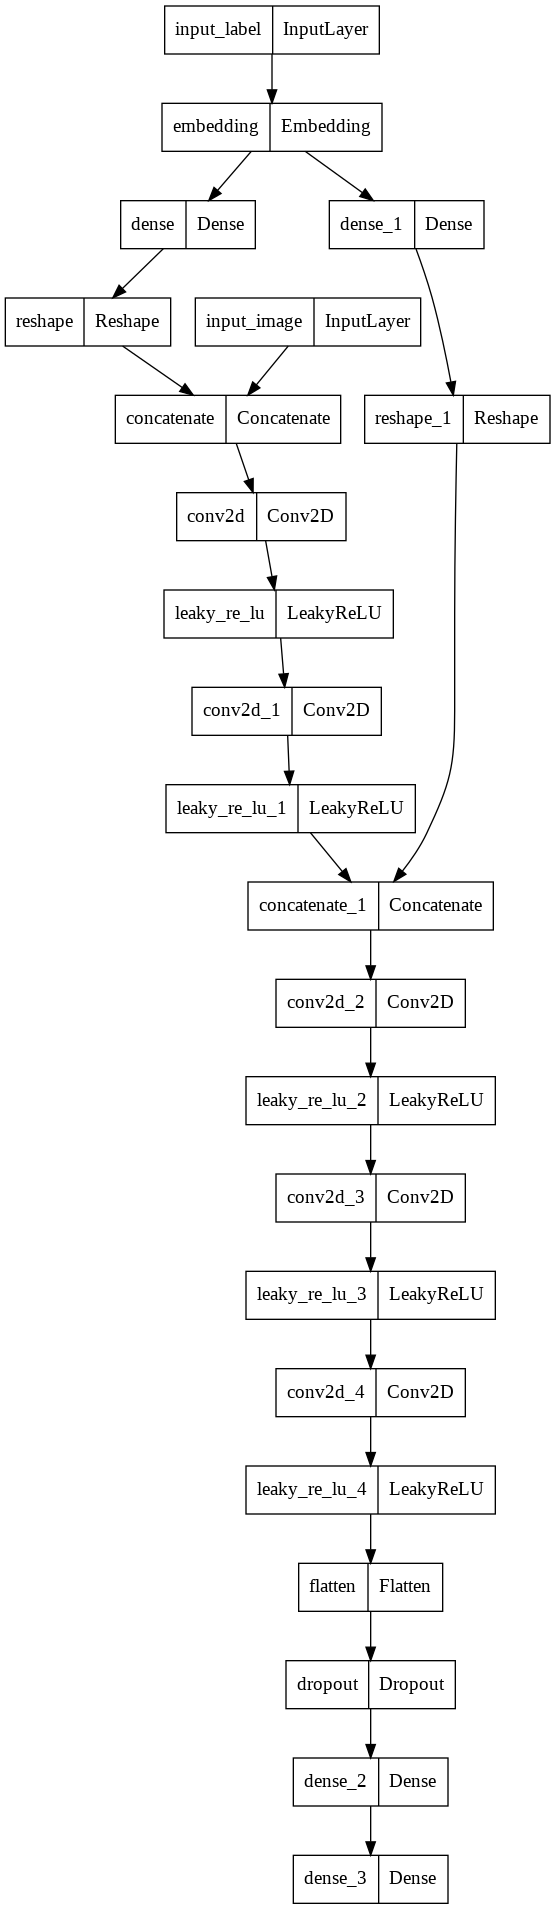

In [6]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [7]:
def define_generator(latent_dim = 100, n_classes = 5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 200)(label_layer_1)
    label_layer_3 = Dense(8 * 8)(label_layer_2)
    label_layer_4 = Reshape((8, 8, 1))(label_layer_3)
    # (8, 8, 1)

    # latent input
    latent_layer = Input(shape=(latent_dim,), name = "input_latent")

    layer_2 = Dense(128 * 8 * 8)(latent_layer)
    layer_2 = Activation("relu")(layer_2)
    layer_2 = Reshape((8, 8, 128))(layer_2)
    layer_2_1 = BatchNormalization(momentum = 0.8)(layer_2)
    # (8, 8, 128)


    concat_layer_1 = Concatenate()([layer_2_1, label_layer_4])
    # (8, 8, 129)

    layer_3 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_1)
    layer_3 = Conv2D(filters = 64, kernel_size = (3,3), padding='same', kernel_initializer = initializers.RandomNormal(0,0.8))(layer_3)
    layer_3 = BatchNormalization(momentum = 0.8)(layer_3)
    layer_3 = LeakyReLU(alpha=0.4)(layer_3)
    # (16, 16, 64)

    layer_4 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(layer_3)
    layer_4 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_4)
    layer_4 = BatchNormalization(momentum = 0.8)(layer_4)
    layer_4 = LeakyReLU(alpha=0.4)(layer_4)
    # (32, 32, 64)

    # label_layer_2_1 = Embedding(n_classes, 100)(label_layer_1)
    label_layer_3_1 = Dense(32 * 32)(label_layer_2)
    label_layer_4_1 = Reshape((32, 32, 1))(label_layer_3_1)
    # label_layer_5_1 = BatchNormalization(momentum = 0.8)(label_layer_4_1)
    # (32, 32, 1)

    concat_layer_2 = Concatenate()([layer_4, label_layer_4_1])
    # (32, 32, 65)


    layer_5 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_2)
    layer_5 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_5)
    layer_5 = BatchNormalization(momentum = 0.8)(layer_5)
    layer_5 = LeakyReLU(alpha=0.4)(layer_5)
    # (64, 64, 64)

    layer_6 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(layer_5)
    layer_6 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_6)
    layer_6 = BatchNormalization(momentum = 0.8)(layer_6)
    layer_6 = LeakyReLU(alpha=0.4)(layer_6)
    # (128, 128, 64)

    # final layer
    output_layer = Conv2D(filters = 3, kernel_size = (3,3), strides=(1,1), activation='tanh', padding='same')(layer_6)

    model = Model([latent_layer,label_layer_1], output_layer)
    return model

b = define_generator(512)
b.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 8192)         4202496     ['input_latent[0][0]']           
                                                                                                  
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 activation (Activation)        (None, 8192)         0           ['dense_5[0][0]']                
                                                                                            

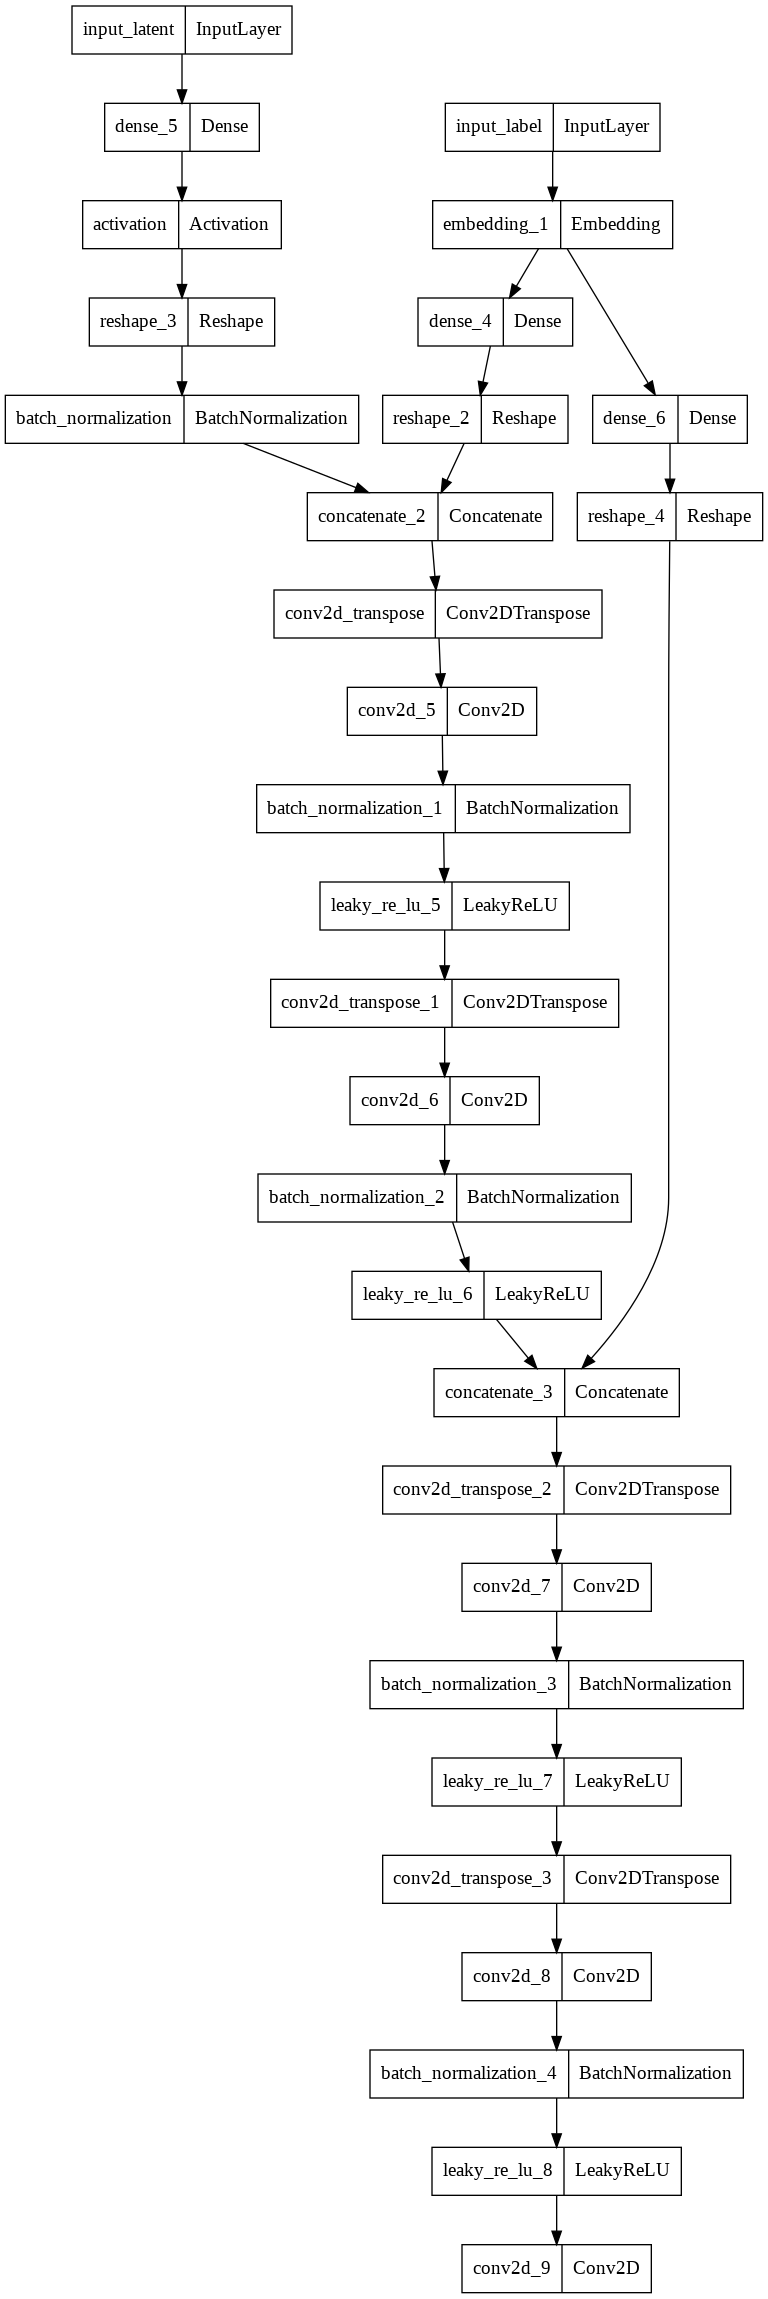

In [8]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [9]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_latent, g_label = g_model.input
  g_output = g_model.output

  d_output = d_model([g_output,g_label])

  model = Model([g_latent, g_label], d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 8192)         4202496     ['input_latent[0][0]']           
                                                                                                  
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 activation (Activation)        (None, 8192)         0           ['dense_5[0][0]']                
                                                                                            

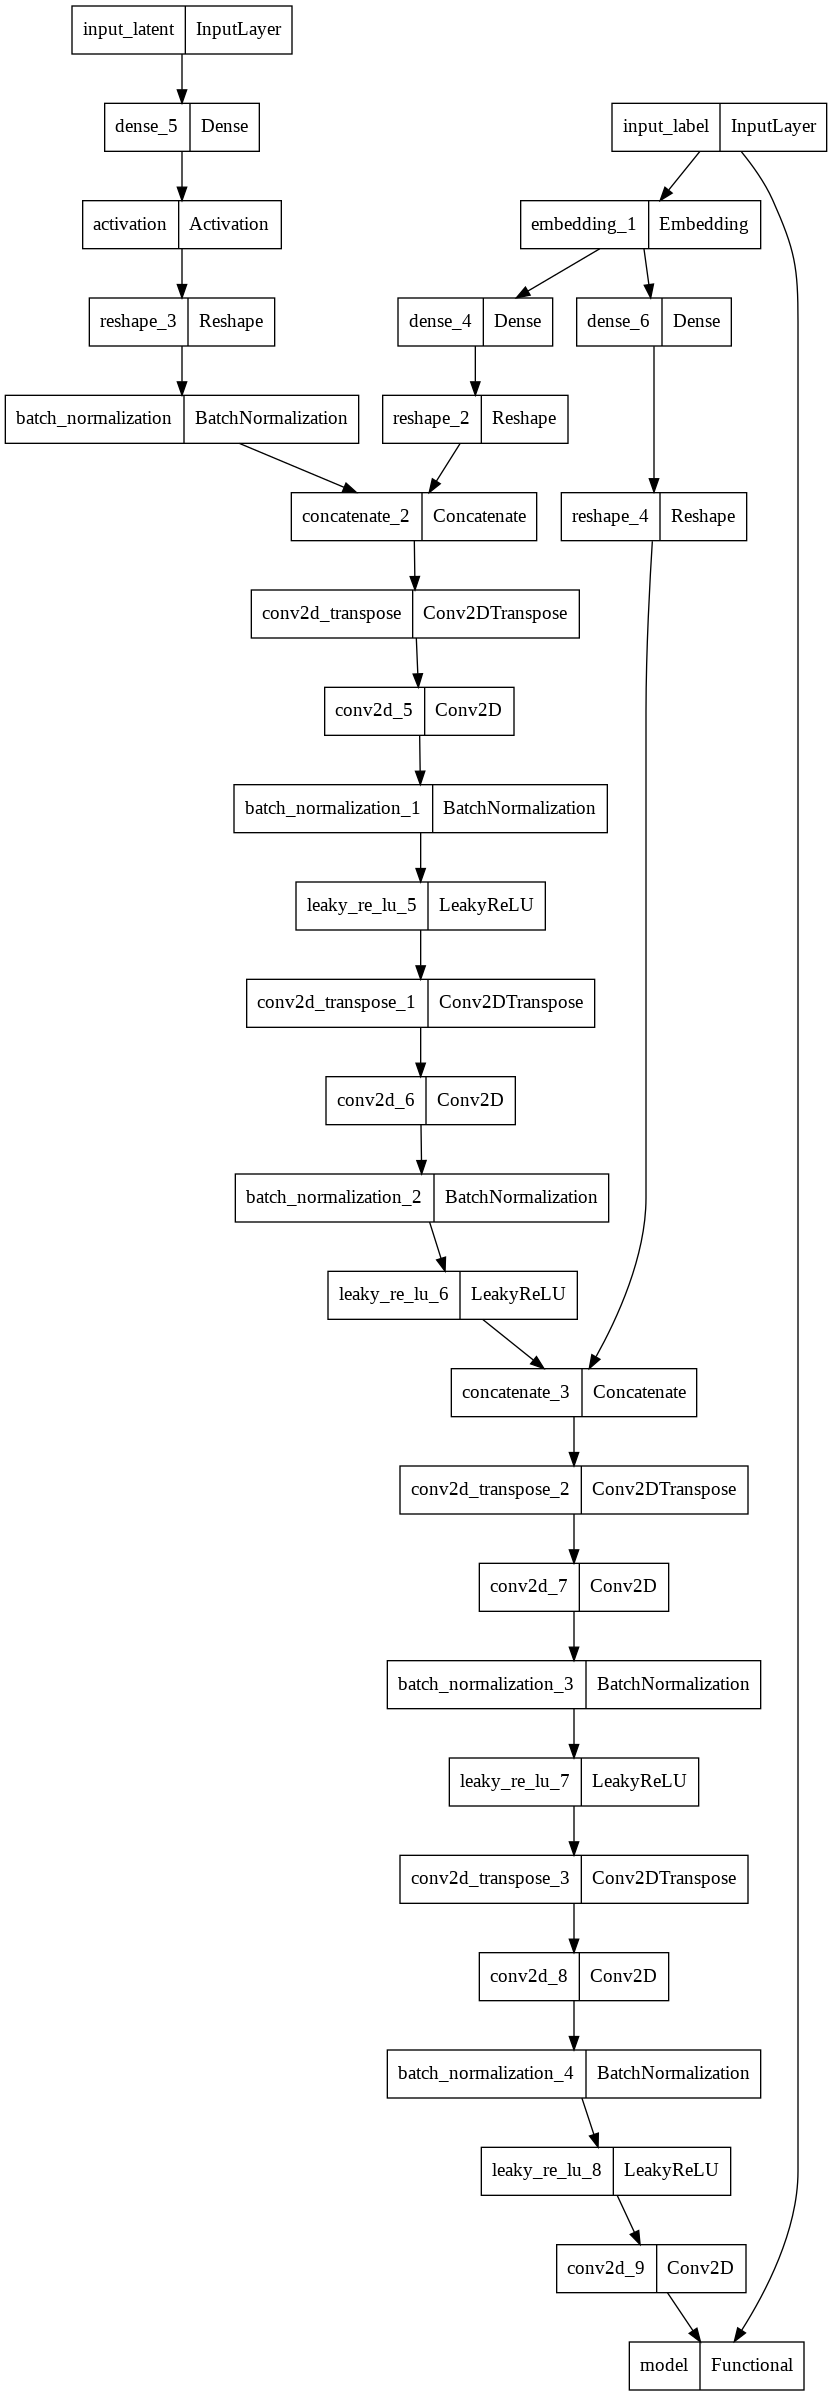

In [10]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Dataset

In [11]:
def load_real_samples():
  # load dataset
  data = np.load("/content/drive/MyDrive/GAN_New_Approch/LSGAN/Abstract_128_combo.npz")
  data = data['a']
  data = np.array(data)
  X = data.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
# k = load_real_samples()
# print("image: ",k.shape)
# print("\nshape/size of the first 16 data: ",k[:16].shape)

## Plot data with label

In [29]:
def save_plot(x_input,n=4):
    plt.figure(figsize=(15,7))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.show()
# plot data
# save_plot(k[:16])

## Generate real sample function

In [13]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	z = np.random.randint(0,5,size=(n_samples))
	y = ones((n_samples, 1))
	return [X,z], y
# d = generate_real_samples(k, 32)
# print("Generate real data as a batch randomly: ",d[0][0].shape)

## Generate latent point function

In [14]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  z = np.random.randint(0,5,size=(n_samples))
  return [z_input,z]
# p = generate_latent_points(512, 32)
# print("Generate latent point(with label) as a batch: ",p[0].shape)

## Generate Fake samples of image with label

In [15]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input,z = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input,z])
	y = zeros((n_samples, 1))
	return [images, z], y
# with tf.device(device_name):
	# kh = generate_fake_samples(b, 512, 32)
	# print("shape of the generated images: ",kh[0][0].shape)

## Summarize the generator model

In [16]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)

In [17]:
def save_figure(generator,a,latent_dim = 512,n=4):
    latent_points, labels = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    X = (X + 1) / 2.0
    # plt.title("Epoch_"+str(a+1),loc = "center")
    plt.figure(figsize=(15,7))
    for j in range(n*n):
        plt.subplot(n, n, j+1)
        plt.imshow(X[j,:,:,:])
        plt.axis('off')
    plt.suptitle("Epoch_"+str(a+1))
    plt.savefig("/content/drive/MyDrive/GAN_New_Approch/LSGAN/Epoch_"+str(a+1))

## Train function

In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("batch per epoch: ", bat_per_epo)
  print("full batch: ",n_batch)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += d_loss1
      # print("real_loss")

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += d_loss2
      # print("fake_loss")

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += g_loss1

    d_loss_real_array.append(d_loss_r)
    d_loss_fake_array.append(d_loss_f)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    if(i%20==0):
        summarize_the_model(g_model,latent_dim)
        save_figure(g_model,i,latent_dim = 512,n=4)
    # g_model.save("g_gan_model_"+str(i)+".h5")
    g_model.save("/content/drive/MyDrive/GAN_New_Approch/LSGAN/generator_model_4.h5")
    np.savez_compressed('/content/drive/MyDrive/GAN_New_Approch/LSGAN/loss_record_4.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)
    # save_figure(g_model,i,latent_dim = 512,n=4)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!

No. of epoch:  150
batch per epoch:  387
full batch:  32
half batch:  16 

************************************************** 


epoch -> [1/150], discriminator_loss_for_real_data = 78.16, discriminator_loss_for_fake_data = 35.19, generator_loss = 367.30



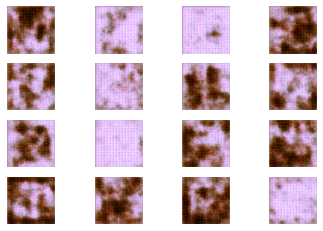



epoch -> [2/150], discriminator_loss_for_real_data = 78.09, discriminator_loss_for_fake_data = 47.05, generator_loss = 277.27



epoch -> [3/150], discriminator_loss_for_real_data = 78.79, discriminator_loss_for_fake_data = 53.28, generator_loss = 265.52



epoch -> [4/150], discriminator_loss_for_real_data = 82.01, discriminator_loss_for_fake_data = 53.37, generator_loss = 245.11



epoch -> [5/150], discriminator_loss_for_real_data = 70.60, discriminator_loss_for_fake_data = 44.95, generator_loss = 284.06



epoch -> [6/150], discriminator_loss_for_real_data = 61.59, discriminator_loss_for_fake_data = 37.83, generator_loss = 299.42



epoch -> [7/150], discriminator_loss_for_real_data = 67.15, discriminator_loss_for_fake_data = 40.22, generator_loss = 279.36



epoch -> [8/150], discriminator_loss_for_real_data = 63.43, discriminator_loss_for_fake_data = 39.17, generator_loss = 282.78



epoch -> [9/150], discriminator_loss_for_real_data = 64.92, discriminator_loss_for_fake_data = 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


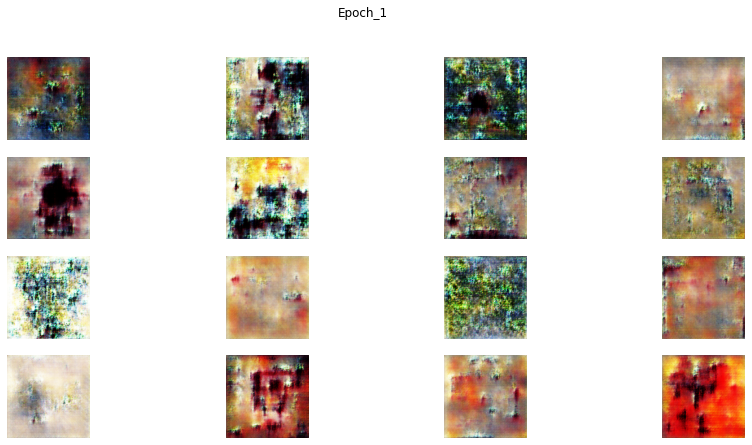



epoch -> [22/150], discriminator_loss_for_real_data = 58.28, discriminator_loss_for_fake_data = 35.93, generator_loss = 286.56



epoch -> [23/150], discriminator_loss_for_real_data = 58.88, discriminator_loss_for_fake_data = 34.69, generator_loss = 286.53



epoch -> [24/150], discriminator_loss_for_real_data = 53.72, discriminator_loss_for_fake_data = 31.76, generator_loss = 295.28



epoch -> [25/150], discriminator_loss_for_real_data = 54.25, discriminator_loss_for_fake_data = 31.83, generator_loss = 295.97



epoch -> [26/150], discriminator_loss_for_real_data = 52.24, discriminator_loss_for_fake_data = 31.58, generator_loss = 293.65



epoch -> [27/150], discriminator_loss_for_real_data = 52.84, discriminator_loss_for_fake_data = 32.56, generator_loss = 293.92



epoch -> [28/150], discriminator_loss_for_real_data = 54.00, discriminator_loss_for_fake_data = 32.96, generator_loss = 298.03



epoch -> [29/150], discriminator_loss_for_real_data = 52.68, discriminator_loss_for_fake

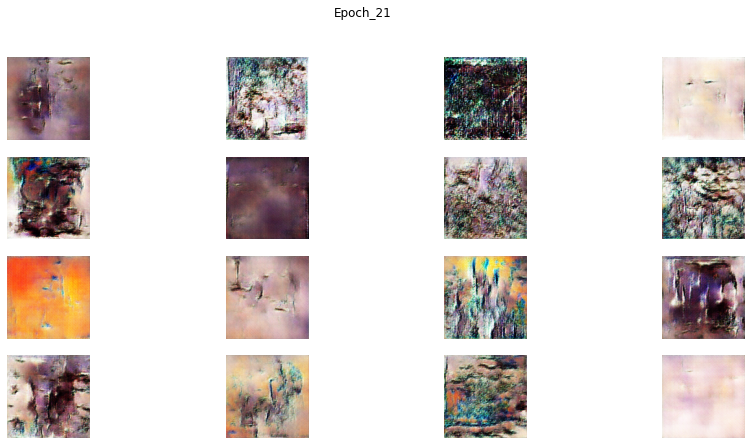



epoch -> [42/150], discriminator_loss_for_real_data = 47.23, discriminator_loss_for_fake_data = 29.58, generator_loss = 293.80



epoch -> [43/150], discriminator_loss_for_real_data = 48.96, discriminator_loss_for_fake_data = 29.11, generator_loss = 293.52



epoch -> [44/150], discriminator_loss_for_real_data = 45.23, discriminator_loss_for_fake_data = 28.55, generator_loss = 293.34



epoch -> [45/150], discriminator_loss_for_real_data = 43.72, discriminator_loss_for_fake_data = 27.03, generator_loss = 302.25



epoch -> [46/150], discriminator_loss_for_real_data = 43.47, discriminator_loss_for_fake_data = 27.07, generator_loss = 304.80



epoch -> [47/150], discriminator_loss_for_real_data = 42.77, discriminator_loss_for_fake_data = 25.94, generator_loss = 302.18



epoch -> [48/150], discriminator_loss_for_real_data = 42.64, discriminator_loss_for_fake_data = 26.64, generator_loss = 304.50



epoch -> [49/150], discriminator_loss_for_real_data = 41.62, discriminator_loss_for_fake

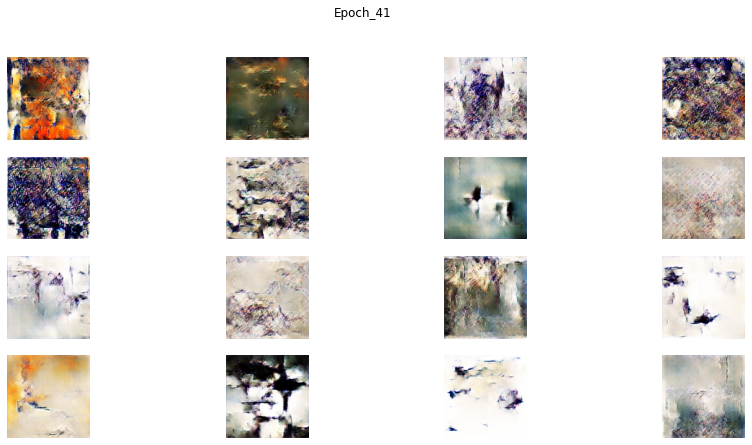



epoch -> [62/150], discriminator_loss_for_real_data = 36.53, discriminator_loss_for_fake_data = 21.41, generator_loss = 312.30



epoch -> [63/150], discriminator_loss_for_real_data = 37.77, discriminator_loss_for_fake_data = 21.87, generator_loss = 310.97



epoch -> [64/150], discriminator_loss_for_real_data = 36.39, discriminator_loss_for_fake_data = 18.91, generator_loss = 317.05



epoch -> [65/150], discriminator_loss_for_real_data = 35.30, discriminator_loss_for_fake_data = 19.49, generator_loss = 320.85



epoch -> [66/150], discriminator_loss_for_real_data = 35.08, discriminator_loss_for_fake_data = 19.12, generator_loss = 319.31



epoch -> [67/150], discriminator_loss_for_real_data = 35.07, discriminator_loss_for_fake_data = 19.96, generator_loss = 322.31



epoch -> [68/150], discriminator_loss_for_real_data = 34.90, discriminator_loss_for_fake_data = 20.13, generator_loss = 317.02



epoch -> [69/150], discriminator_loss_for_real_data = 34.70, discriminator_loss_for_fake

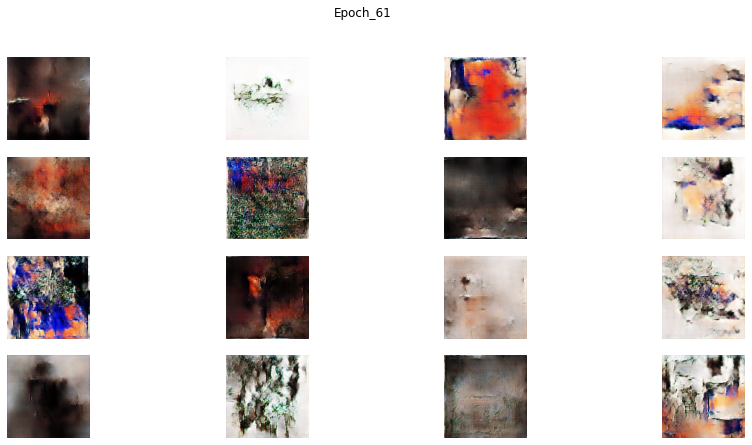



epoch -> [82/150], discriminator_loss_for_real_data = 33.40, discriminator_loss_for_fake_data = 17.09, generator_loss = 325.79



epoch -> [83/150], discriminator_loss_for_real_data = 32.56, discriminator_loss_for_fake_data = 16.55, generator_loss = 326.60



epoch -> [84/150], discriminator_loss_for_real_data = 29.73, discriminator_loss_for_fake_data = 15.01, generator_loss = 331.18



epoch -> [85/150], discriminator_loss_for_real_data = 31.00, discriminator_loss_for_fake_data = 15.65, generator_loss = 328.08



epoch -> [86/150], discriminator_loss_for_real_data = 30.39, discriminator_loss_for_fake_data = 16.05, generator_loss = 326.88



epoch -> [87/150], discriminator_loss_for_real_data = 31.25, discriminator_loss_for_fake_data = 16.15, generator_loss = 327.22



epoch -> [88/150], discriminator_loss_for_real_data = 30.35, discriminator_loss_for_fake_data = 14.71, generator_loss = 328.26



epoch -> [89/150], discriminator_loss_for_real_data = 30.67, discriminator_loss_for_fake

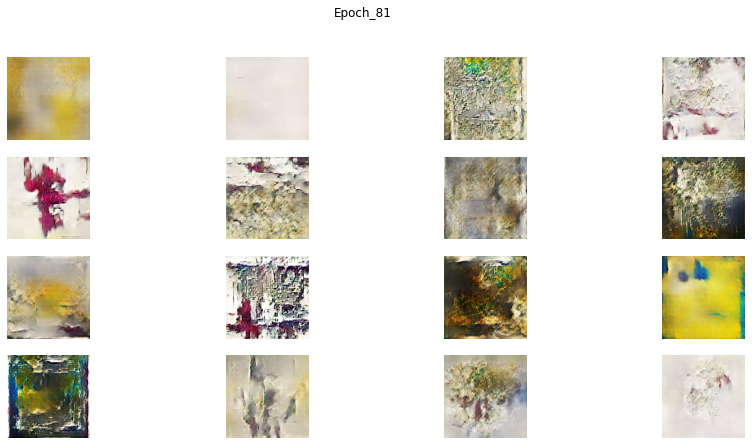



epoch -> [102/150], discriminator_loss_for_real_data = 28.37, discriminator_loss_for_fake_data = 13.04, generator_loss = 334.18



epoch -> [103/150], discriminator_loss_for_real_data = 27.74, discriminator_loss_for_fake_data = 14.04, generator_loss = 335.91



epoch -> [104/150], discriminator_loss_for_real_data = 28.44, discriminator_loss_for_fake_data = 13.78, generator_loss = 336.14



epoch -> [105/150], discriminator_loss_for_real_data = 27.68, discriminator_loss_for_fake_data = 12.89, generator_loss = 332.38



epoch -> [106/150], discriminator_loss_for_real_data = 28.82, discriminator_loss_for_fake_data = 13.50, generator_loss = 334.43



epoch -> [107/150], discriminator_loss_for_real_data = 26.85, discriminator_loss_for_fake_data = 12.29, generator_loss = 337.32



epoch -> [108/150], discriminator_loss_for_real_data = 27.38, discriminator_loss_for_fake_data = 11.97, generator_loss = 337.70



epoch -> [109/150], discriminator_loss_for_real_data = 27.86, discriminator_loss_

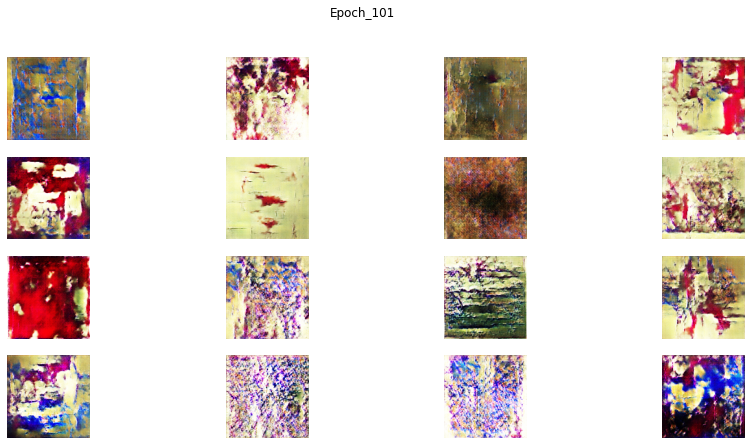



epoch -> [122/150], discriminator_loss_for_real_data = 25.74, discriminator_loss_for_fake_data = 11.61, generator_loss = 336.51



epoch -> [123/150], discriminator_loss_for_real_data = 25.62, discriminator_loss_for_fake_data = 11.22, generator_loss = 337.11



epoch -> [124/150], discriminator_loss_for_real_data = 25.33, discriminator_loss_for_fake_data = 11.25, generator_loss = 338.82



epoch -> [125/150], discriminator_loss_for_real_data = 25.99, discriminator_loss_for_fake_data = 12.22, generator_loss = 338.92



epoch -> [126/150], discriminator_loss_for_real_data = 24.16, discriminator_loss_for_fake_data = 10.48, generator_loss = 341.71



epoch -> [127/150], discriminator_loss_for_real_data = 25.73, discriminator_loss_for_fake_data = 11.03, generator_loss = 337.90



epoch -> [128/150], discriminator_loss_for_real_data = 25.39, discriminator_loss_for_fake_data = 11.48, generator_loss = 339.90



epoch -> [129/150], discriminator_loss_for_real_data = 26.71, discriminator_loss_

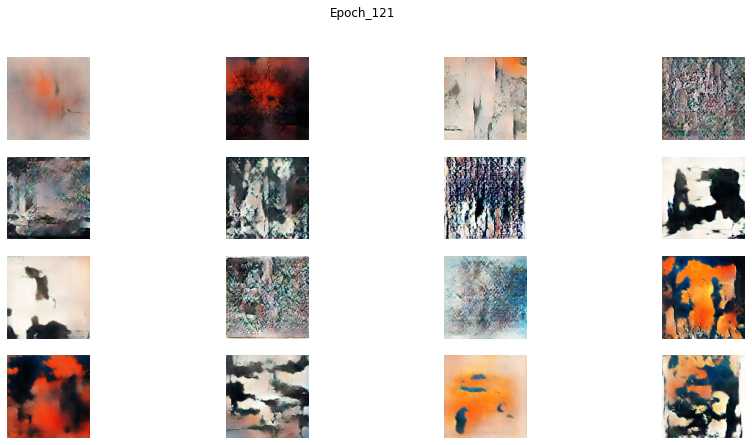



epoch -> [142/150], discriminator_loss_for_real_data = 24.04, discriminator_loss_for_fake_data = 10.03, generator_loss = 339.51



epoch -> [143/150], discriminator_loss_for_real_data = 25.05, discriminator_loss_for_fake_data = 10.23, generator_loss = 343.07



epoch -> [144/150], discriminator_loss_for_real_data = 24.22, discriminator_loss_for_fake_data = 10.75, generator_loss = 342.38



epoch -> [145/150], discriminator_loss_for_real_data = 24.29, discriminator_loss_for_fake_data = 9.93, generator_loss = 341.73



epoch -> [146/150], discriminator_loss_for_real_data = 23.82, discriminator_loss_for_fake_data = 9.95, generator_loss = 344.66



epoch -> [147/150], discriminator_loss_for_real_data = 23.48, discriminator_loss_for_fake_data = 9.89, generator_loss = 343.72



epoch -> [148/150], discriminator_loss_for_real_data = 24.76, discriminator_loss_for_fake_data = 10.21, generator_loss = 344.74



epoch -> [149/150], discriminator_loss_for_real_data = 22.74, discriminator_loss_for

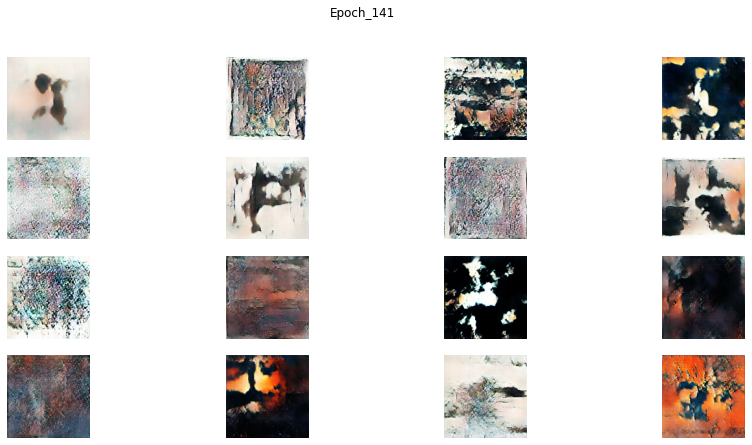

In [19]:
with tf.device(device_name):

  latent_dim = 512
  n_epochs = 150
  n_batch = 32
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_real_array, d_loss_fake_array, g_loss_array = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

## Plot Loss Values

In [20]:
loaded = np.load('/content/drive/MyDrive/GAN_New_Approch/LSGAN/loss_record_4.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)
print(loaded['c'].shape)

(150,)
(150,)
(150,)


In [21]:
import matplotlib.pyplot as plot

d_loss_real_array = loaded['a']
d_loss_fake_array = loaded['b']

In [22]:
d_loss = np.array([(i+j) for i,j in zip(d_loss_real_array, d_loss_fake_array)])

In [23]:
g_loss = loaded['c']

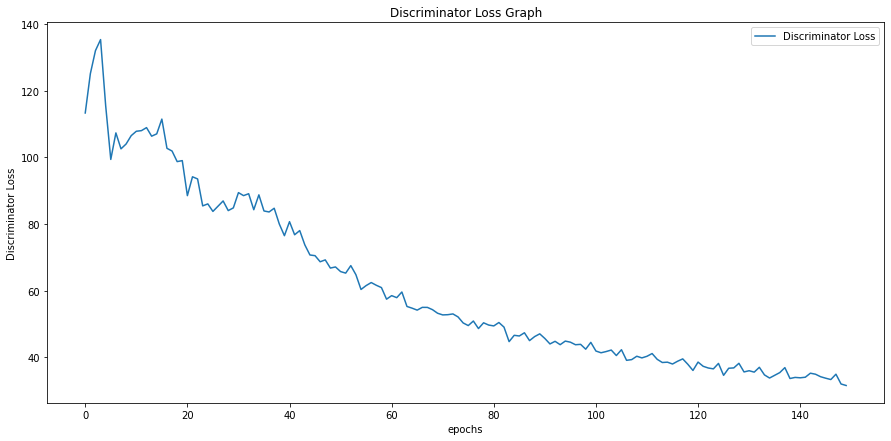

In [24]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.savefig("/content/drive/MyDrive/GAN_New_Approch/LSGAN/Discriminator_Loss_Graph")
plt.show()

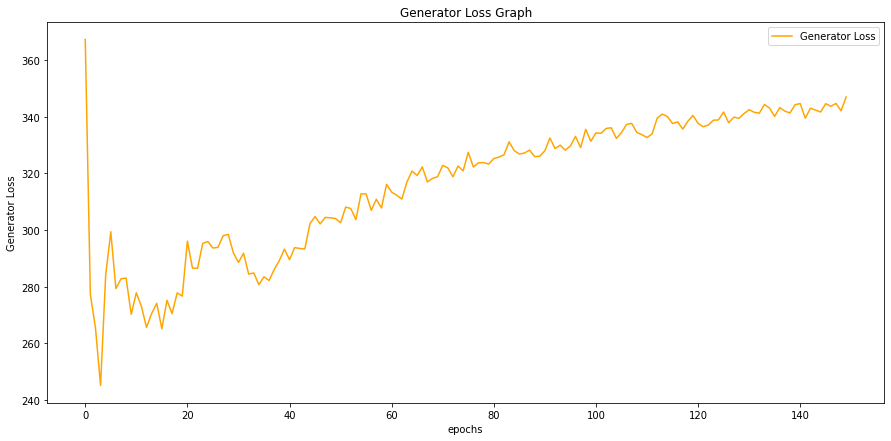

In [25]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.savefig("/content/drive/MyDrive/GAN_New_Approch/LSGAN/Generator_Loss_Graph")
plt.show()

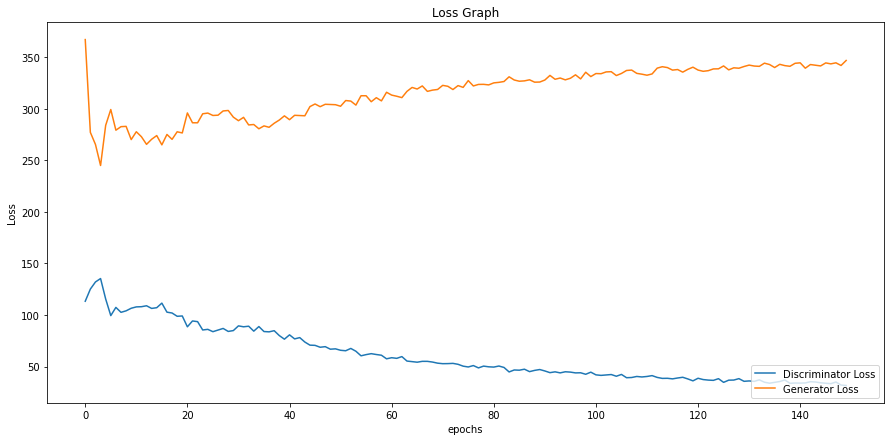

In [26]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.savefig("/content/drive/MyDrive/GAN_New_Approch/LSGAN/Loss_Graph")
plt.show()

# Prediction

In [27]:
generator = tensorflow.keras.models.load_model("/content/drive/MyDrive/GAN_New_Approch/LSGAN/generator_model_4.h5")

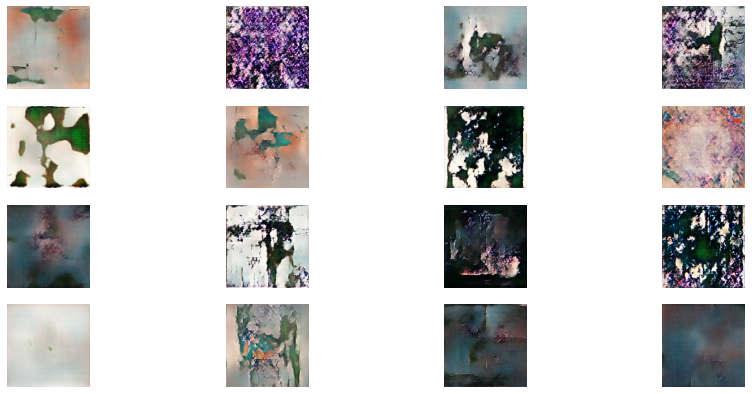

In [33]:
latent_dim = 512
n_samples = 16
z_input, labels = generate_latent_points(latent_dim, n_samples)
# print("latent points(latent points and labels): ",z_input.shape, labels.shape)
data = [z_input,labels]
pred = generator.predict(data)
pred = (pred + 1 ) / 2.0
# print("\nGenerated images with labels: ",pred.shape,'\n')
# plt.figure(figsize=(15,7))
save_plot(pred,n=4)
# plt.imshow(pred[0])
# plt.show()

                                              -:END:-